In [19]:
#loading and normalize CIFAR10
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as Data

transform=transforms.Compose([transforms.ToTensor(),
                             transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

trainset=torchvision.datasets.CIFAR10(root='./data',train=True,download=False,transform=transform)
trainloader=Data.DataLoader(trainset,batch_size=4,shuffle=True,num_workers=2)

testset=torchvision.datasets.CIFAR10(root='./data',train=False,download=False,transform=transform)
testloader=Data.DataLoader(testset,batch_size=4,shuffle=True,num_workers=2)

classes=('plane','car','bird','cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(trainset)   #数据大小
print(testset)

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None
Dataset CIFAR10
    Number of datapoints: 10000
    Split: test
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None


32 tensor(0)


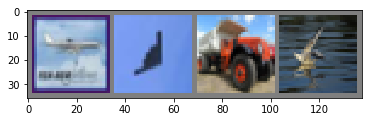

plane plane truck  bird


In [34]:
#show some of the training images
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    img=img/2+0.5
    npimg=img.numpy()   #转换为numpy图片
    plt.imshow(np.transpose(npimg,(1,2,0)))

#get some random training image
dataiter=iter(trainloader)
images,labels=dataiter.next()
print(images[0].size(2),labels[0])   #图片尺寸

#show images
imshow(torchvision.utils.make_grid(images))
plt.show()
#print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [3]:
#define a Convolution Neural Network
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=nn.Conv2d(3,6,5)
        self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(6,16,5)
        self.fc1=nn.Linear(16*5*5,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
        
    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=x.view(-1,16*5*5)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x
    
net=Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [15]:
#Define loss function and optimizer
loss_func=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

In [24]:
#train the network
for epoch in range(3):
    running_loss=0.0
    for i,data in enumerate(trainloader,0):
        inputs,labels=data
        
        #zero the parameters gradient
        optimizer.zero_grad()
        
        #forward,backward,optimize
        output=net(inputs)
        loss=loss_func(output,labels)
        loss.backward()
        optimizer.step()
        
        #print statistics
        running_loss+=loss.item()
        if i % 2000 == 1999:      #print every 2000 minibatch
            print('[%d,%5d] train loss:%.3f' % (epoch+1,i+1,running_loss/2000))
            running_loss=0.0
        
print('Finish training')

[1, 2000] train loss:1.240
[1, 4000] train loss:1.206
[1, 6000] train loss:1.213
[1, 8000] train loss:1.192
[1,10000] train loss:1.192
[1,12000] train loss:1.198
[2, 2000] train loss:1.100
[2, 4000] train loss:1.129
[2, 6000] train loss:1.114
[2, 8000] train loss:1.116
[2,10000] train loss:1.110
[2,12000] train loss:1.115
[3, 2000] train loss:1.031
[3, 4000] train loss:1.036
[3, 6000] train loss:1.062
[3, 8000] train loss:1.049
[3,10000] train loss:1.046
[3,12000] train loss:1.049
Finish training


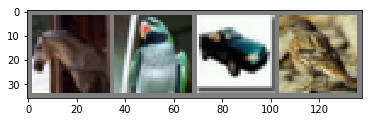

ground_truth:  horse  bird   car  bird


In [22]:
#test the network on the testdata
dataiter=iter(testloader)
images,labels=dataiter.next()

#print images
imshow(torchvision.utils.make_grid(images))
plt.show()
print('ground_truth: ',' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [25]:
outputs=net(images)
_,predictions=torch.max(outputs,1)
print('Predicted: ',' '.join('%5s' % classes[predictions[j]] for j in range(4)))

Predicted:  horse   cat plane  frog


In [30]:
#network performance on the whole testset
correct=0
total=0
with torch.no_grad():
    for data in testloader:
        images,labels=data
        outputs=net(images)
        _,predicted=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
    
print('Accuracy of the network on the 10000 test images:%d %%' % (100*correct/total))

Accuracy of the network on the 10000 test images:61 %


In [33]:
#network performance on each classes
class_correct=list(0 for i in range(10))
class_total=list(0 for i in range(10))
with torch.no_grad():
    for data in testloader:
        images,labels=data
        outputs=net(images)
        _,predicted=torch.max(outputs.data,1)
        c=(predicted==labels).squeeze()
        for i in range(4):
            label=labels[i]
            class_correct[label]+=c[i].item()
            class_total[label]+=1
        
for i in range(10):
    print("Accuracy of %5s : %2d %%" % (classes[i],100*class_correct[i]/class_total[i]))

Accuracy of plane : 60 %
Accuracy of   car : 75 %
Accuracy of  bird : 50 %
Accuracy of   cat : 39 %
Accuracy of  deer : 63 %
Accuracy of   dog : 42 %
Accuracy of  frog : 74 %
Accuracy of horse : 57 %
Accuracy of  ship : 82 %
Accuracy of truck : 65 %
